# 仿真场景迟滞测试
初始状态10m/s稳态，前车10s减速至5m/s，维持100s后，再10s加速至15m/s

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("ticks")

matplotlib.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
plt.rc('font',family='Times New Roman')
mm = 1 / 25.4  # mm转inch
fontsize = 10  # 7磅/pt/point
_width = 70 * mm  # 图片宽度英寸
_ratio = 5 / 7  # 图片长宽比
figsize = (_width, _width * _ratio)

In [3]:
from trasim_simplified.core.constant import CFM
from trasim_simplified.util.hysteresis.intensity import cal_sv_intensity
from trasim_simplified.util.hysteresis.sim_scenario import slow_to_go_sim
from trasim_simplified.core.kinematics.cfm import get_cf_default_param, get_cf_func, get_cf_equilibrium
from trasim_simplified.core.kinematics.cfm.CFModel_IDM import cf_IDM_equilibrium_module, cf_IDM_acc_module, cf_IDM_acc, cf_IDM_equilibrium

cf_name = CFM.IDM
param_names = ["s0", "v0", "T", "omega", "d", "delta"]
# param_names = ["k1", "k2", "thw", "s0"]
cf_func = get_cf_func(cf_name)
cf_e = get_cf_equilibrium(cf_name)
# cf_func = cf_IDM_acc_module
# cf_func = cf_IDM_acc
# cf_e = cf_IDM_equilibrium_module
# cf_e = cf_IDM_equilibrium

In [4]:
import pandas as pd

param_df: pd.DataFrame = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_full_param_df" + f"_{cf_name}.pkl")
param_df

,s0,v0,T,omega,d,delta,Pair_ID,ObjV
0,10.000000,40.000000,0.436868,0.548210,10.000000,10.0,10,0.863981
1,7.737167,24.353724,0.476107,1.981402,2.087164,4.0,12,0.576711
2,10.000000,40.000000,1.109293,0.605000,0.407477,10.0,14,1.388066
3,6.811732,17.958565,0.733120,2.752649,10.000000,7.0,15,0.543265
4,0.100000,17.043753,0.805630,1.015823,9.997592,6.0,17,0.668795
...,...,...,...,...,...,...,...,...
685,5.767894,10.000000,0.379805,1.382309,9.999943,2.0,6569,0.641105
686,10.000000,40.000000,0.525731,0.771206,10.000000,10.0,6597,1.838980
687,5.596684,10.007324,0.590291,1.280191,3.240674,4.0,6599,0.277605
688,2.435371,25.120707,2.259007,1.832077,0.513617,2.0,6603,0.952197


In [5]:
from trasim_simplified.util.calibrate.clb_cf_model import cf_param_types
cf_param = param_df[param_names].describe().loc["mean"].to_dict()
cf_param = {param_name: (round(cf_param[param_name]) if cf_param_types[cf_name][param_name] == 1 else cf_param[param_name]) for param_name in param_names}
cf_param

Using geatpy


{'s0': 4.468223508337269,
 'v0': 22.986566792363707,
 'T': 0.9752881605728811,
 'omega': 2.506088917359062,
 'd': 5.5230330247464385,
 'delta': 6}

In [6]:
def single_run(cf_func_, cf_param_, cf_e_, lv=False):
    dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_, dec_lx_, acc_lx_ = slow_to_go_sim(cf_func_, cf_param_, cf_e=cf_e_, warmup_time=100, dec_time=10, slow_time=100, acc_time=10, hold_time=100, init_v=10, dv=5)
    vs_results = cal_sv_intensity(dec_s_, dec_v_, acc_s_, acc_v_, cf_e_, cf_param_)
    if lv:
        return {**cf_param_, **vs_results}, (dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_, dec_lx_, acc_lx_)
    else:
        return {**cf_param_, **vs_results}, (dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_)

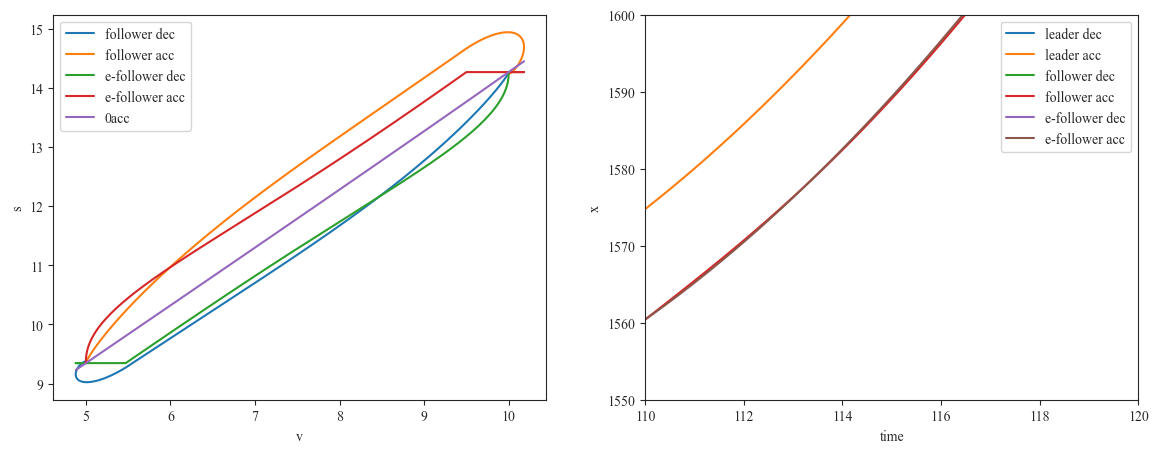

In [8]:
# 迟滞计算图
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax = ax.flatten()
ax: list[plt.Axes] = ax
fig: plt.Figure = fig

result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, dec_lv, acc_lv, dec_lx, acc_lx) = single_run(cf_func, cf_param, cf_e, lv=True)
ax[0].plot(dec_v, dec_s, label="follower dec")
ax[0].plot(acc_v, acc_s, label="follower acc")
ax[0].plot(dec_v, cf_e(**cf_param, speed=dec_lv), label="e-follower dec")
ax[0].plot(acc_v, cf_e(**cf_param, speed=acc_lv), label="e-follower acc")
min_v = min(min(dec_v), min(acc_v), min(dec_lv), min(acc_lv))
max_v = max(max(dec_v), max(acc_v), max(dec_lv), max(acc_lv))
ax[0].plot(np.linspace(min_v, max_v, 10), cf_e(**cf_param, speed=np.linspace(min_v, max_v, 10)), label="0acc")

ax[0].set_xlabel("v")
ax[0].set_ylabel("s")
ax[0].legend()

ax[1].plot(np.arange(len(dec_a)) * 0.1, dec_lx, label="leader dec")
ax[1].plot(len(dec_a) * 0.1 + np.arange(len(acc_a)) * 0.1, acc_lx, label="leader acc")
ax[1].plot(np.arange(len(dec_a)) * 0.1, dec_lx - dec_s - 5, label="follower dec")
ax[1].plot(len(dec_a) * 0.1 + np.arange(len(acc_a)) * 0.1, acc_lx - acc_s - 5, label="follower acc")

ax[1].plot(np.arange(len(dec_a)) * 0.1, dec_lx - 5 - cf_e(**cf_param, speed=dec_lv), label="e-follower dec")
ax[1].plot(len(dec_a) * 0.1 + np.arange(len(acc_a)) * 0.1, acc_lx - 5 - cf_e(**cf_param, speed=acc_lv), label="e-follower acc")
ax[1].set_xlabel("time")
ax[1].set_ylabel("x")
ax[1].set_xlim([110, 120])
ax[1].set_ylim([1550, 1600])
ax[1].legend()

# 单参数迟滞强度敏感性分析

In [9]:
def get_bins_avg(param_name_, param_range_: np.ndarray, data_: pd.DataFrame):
    # 将数据按照第二维度分区并计算分区均值
    data = data_.copy()
    bins_num = 10
    width = (param_range_[-1] - param_range_[0]) / bins_num
    data['Partition'] = (data[param_name_].apply(lambda x: ((x - param_range_[0]) // width) * width + param_range_[0] + width / 2))
    data.sort_values(by="Partition", inplace=True)
    data.pop("hys_type")
    partition_means = data.groupby('Partition').mean().reset_index()
    return partition_means

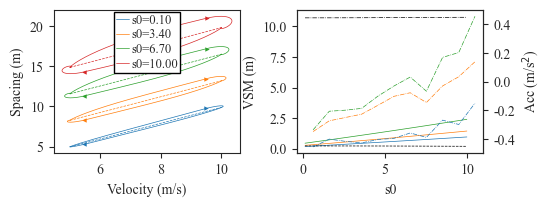

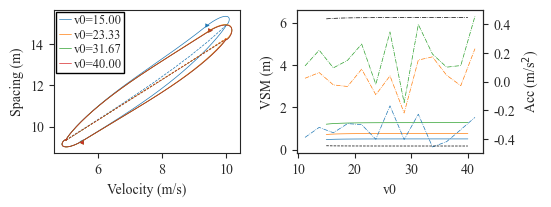

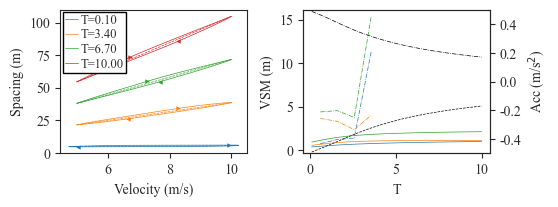

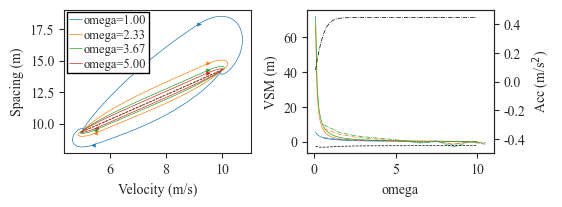

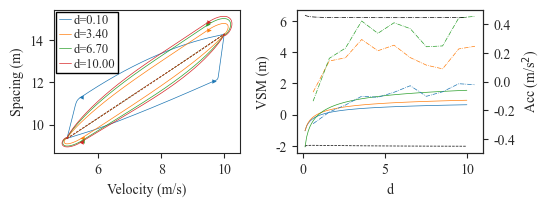

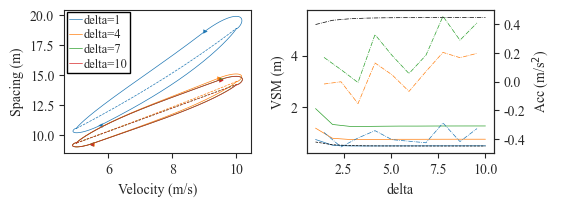

In [18]:
from trasim_simplified.util.calibrate.clb_cf_model import cf_param_ranges

%matplotlib inline
mm = 1 / 25.4  # mm转inch
fontsize = 10  # 7磅/pt/point
_width = 70 * 2 * mm  # 图片宽度英寸
_ratio = 5 / 14  # 图片长宽比
figsize = (_width, _width * _ratio)

# twin_type = "v_std"  # "acc", "v_std"
twin_type = "acc"  # "acc", "v_std"

df_param_hysteresis_merge = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\df_param_hysteresis_merge_IDM.pkl")

for param_name in param_names:
    param_range = cf_param_ranges[cf_name][param_name]
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax: list[plt.Axes] = ax
    fig: plt.Figure = fig
    # fig.suptitle(cf_name + ":" + param_name)
    results = []
    num = 4
    param_values = np.linspace(param_range[0], param_range[1], num)
    # 特殊案例处理
    if cf_name == CFM.IDM:
        if param_name == "v0":
            param_values = np.linspace(15, 40, num)
        if param_name == "delta":
            param_values = np.linspace(1, 10, num)
        if param_name == "omega":
            param_values = np.linspace(1, 5, num)
    if cf_name == CFM.ACC:
        if param_name == "k1":
            param_values = np.linspace(0.1, 1, num)
    
    temp_a = []
    for i, param_value in enumerate(param_values):
        cf_param_copy = cf_param.copy()
        cf_param_copy[param_name] = param_value if cf_param_types[cf_name][param_name] == 0 else round(param_value)
        param_value = cf_param_copy[param_name]
        result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a) = single_run(cf_func, cf_param_copy, cf_e)
        
        # 进行sv轨迹的绘制
        temp: list[plt.Line2D] = ax[0].plot(dec_v, dec_s, linewidth=0.5)
        ax[0].plot(acc_v, acc_s, color=temp[-1].get_color(), label=f"{param_name}={param_value:.2f}" if param_name != "delta" else f"{param_name}={round(param_value)}", linewidth=0.5)
        ax[0].set_xlabel("speed (m/s)", fontsize=fontsize)
        ax[0].set_ylabel("Spacing (m)", fontsize=fontsize)
        ax[0].plot(np.linspace(5, 10, 10), cf_e(**cf_param_copy, speed=np.linspace(5, 10, 10)), color=temp[-1].get_color(), linestyle="--", linewidth=0.5)
        # 绘制前车完成减速时的后车状态
        ax[0].scatter(dec_v[100], dec_s[100], color=temp[-1].get_color(), marker="<", s=10, linewidths=0)
        ax[0].scatter(acc_v[100], acc_s[100], color=temp[-1].get_color(), marker=">", s=10, linewidths=0)

    num = 100
    param_values_ = np.linspace(param_range[0], param_range[1], num)
    # 特殊案例处理
    if cf_name == CFM.IDM:
        if param_name == "v0":
            param_values_ = np.linspace(15, 40, 36)
        if param_name == "delta":
            param_values_ = np.linspace(1, 10, 11)
    if cf_name == CFM.ACC:
        if param_name == "k1":
            param_values_ = np.linspace(0.1, 1, num)
    
    dec_avg_acc_results = []
    acc_avg_acc_results = []
    dec_std_v_results = []
    acc_std_v_results = []
    
    for i, param_value in enumerate(param_values_):
        cf_param_copy = cf_param.copy()
        cf_param_copy[param_name] = param_value if cf_param_types[cf_name][param_name] == 0 else round(param_value)
        result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a) = single_run(cf_func, cf_param_copy, cf_e)
        results.append(result)
        dec_avg_acc_results.append(np.mean(dec_a[: 100]))
        acc_avg_acc_results.append(np.mean(acc_a[: 100]))
        dec_std_v_results.append(np.std(dec_v))
        acc_std_v_results.append(np.std(acc_v))

    # 进行迟滞强度的绘制
    line1, = ax[1].plot(param_values_, [result["dec_vs"] for result in results], label="VSM(Dec)", linewidth=0.5)
    line2, = ax[1].plot(param_values_, [result["acc_vs"] for result in results], label="VSM(Acc)", linewidth=0.5)
    line3, = ax[1].plot(param_values_, [result["total_vs"] for result in results], label="VSM(Full)", linewidth=0.5)
    ax[1].set_xlabel(param_name, fontsize=fontsize)
    ax[1].set_ylabel("VSM (m)", fontsize=fontsize)
    
    partition_means = get_bins_avg(param_name, param_values_, df_param_hysteresis_merge)
    line4, = ax[1].plot(partition_means["Partition"], partition_means["dec_vs"], label="VSM(Dec) real", linewidth=0.5, color=line1.get_color(), linestyle="-.")
    line5, = ax[1].plot(partition_means["Partition"], partition_means["acc_vs"], label="VSM(Acc) real", linewidth=0.5, color=line2.get_color(), linestyle="-.")
    line6, = ax[1].plot(partition_means["Partition"], partition_means["total_vs"], label="VSM(Full) real", linewidth=0.5, color=line3.get_color(), linestyle="-.")
    
    if twin_type == "acc":
        ax_twin = ax[1].twinx()
        line7, = ax_twin.plot(param_values_, dec_avg_acc_results, label="Acc avg(Dec)", linewidth=0.5, color="k", linestyle="--")
        line8, = ax_twin.plot(param_values_, acc_avg_acc_results, label="Acc avg(Acc)", linewidth=0.5, color="k", linestyle="-.")
        ax_twin.set_ylabel("Acc (m/s$^2$)", fontsize=fontsize)
        ax_twin.set_ylim([-0.5, 0.5])
    elif twin_type == "v_std":
        ax_twin = ax[1].twinx()
        line7, = ax_twin.plot(param_values_, dec_std_v_results, label="V std(Dec)", linewidth=0.5, color="k", linestyle="--")
        line8, = ax_twin.plot(param_values_, acc_std_v_results, label="V std(Acc)", linewidth=0.5, color="k", linestyle="-.")
        ax_twin.set_ylabel("Std(velocity) (m/s)", fontsize=fontsize)
        # ax_twin.set_ylim([0, 2])

    # ax_twin.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8], fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=1, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)
    # ax_twin.legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=1, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)
    
    ax[0].legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=1, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)

    fig.subplots_adjust(wspace=0.3, bottom=0.22, top=0.95, right=0.88, left=0.1)
    
    fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\param_value_change_{}_{}.tif".format(cf_name, param_name), dpi=500, pil_kwargs={"compression": "tiff_lzw"})

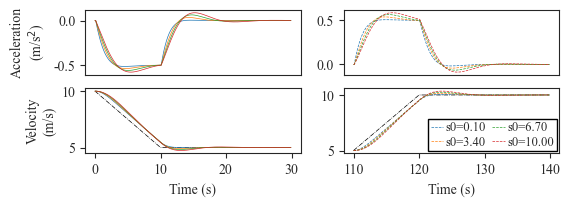

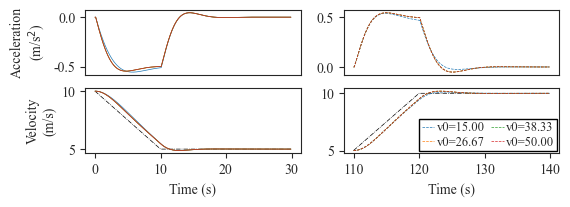

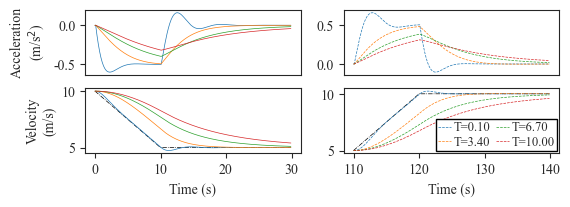

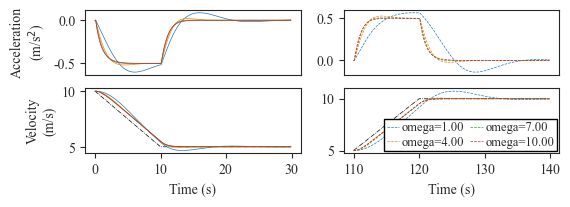

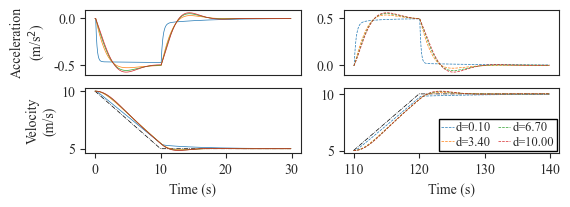

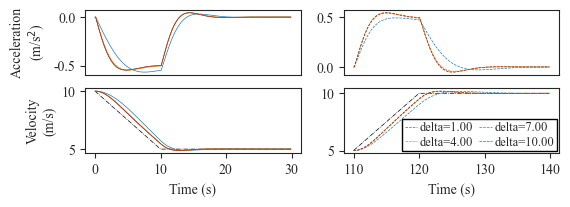

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from trasim_simplified.util.calibrate.clb_cf_model import cf_param_ranges

%matplotlib inline
mm = 1 / 25.4  # mm转inch
fontsize = 10  # 7磅/pt/point
_width = 70 * 2 * mm  # 图片宽度英寸
_ratio = 5 / 14  # 图片长宽比
figsize = (_width, _width * _ratio)

acc_step = 300
dec_step = 300

for param_name in param_names:

    param_range = cf_param_ranges[cf_name][param_name]
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes: list[plt.Axes] = axes.flatten()
    ax: plt.Axes = axes[0]
    fig: plt.Figure = fig
    results = []
    num = 4
    param_values = np.linspace(param_range[0], param_range[1], num)
    # 特殊案例处理
    if cf_name == CFM.IDM:
        if param_name == "v0":
            param_values = np.linspace(15, 50, num)
        if param_name == "delta":
            param_values = np.linspace(1, 10, num)
        if param_name == "omega":
            param_values = np.linspace(1, 10, num)

    temp_a = []

    for i, param_value in enumerate(param_values):
        cf_param_copy = cf_param.copy()
        cf_param_copy[param_name] = param_value if cf_param_types[cf_name][param_name] == 0 else round(param_value)
        result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, dec_lv, acc_lv, dec_lx, acc_lx) = single_run(cf_func, cf_param_copy, cf_e, lv=True)

        if i == 0:
            ax = axes[2]
            # 绘制前车速度
            ax.plot(np.arange(dec_step) * 0.1, dec_lv[: dec_step], color="k", linestyle="-.", linewidth=0.5, label="leader")
            ax = axes[3]
            ax.plot(len(dec_v) * 0.1 + np.arange(acc_step) * 0.1, acc_lv[: acc_step], color="k", linestyle="-.", linewidth=0.5)

        ax = axes[2]
        temp = ax.plot(np.arange(dec_step) * 0.1, dec_v[: dec_step], linewidth=0.5, label=f"{param_name}={param_value:.2f}" if param_name != "delta" else f"{param_name}={round(param_value)}")
        ax = axes[3]
        ax.plot(len(dec_v) * 0.1 + np.arange(acc_step) * 0.1, acc_v[: acc_step], color=temp[-1].get_color(), linewidth=0.5, label=f"{param_name}={param_value:.2f}", linestyle="--")

        ax = axes[0]
        # 进行sv轨迹的绘制
        temp: list[plt.Line2D] = ax.plot(np.arange(dec_step) * 0.1, dec_a[: dec_step], linewidth=0.5)
        ax = axes[1]
        ax.plot(len(dec_a) * 0.1 + np.arange(acc_step) * 0.1, acc_a[: acc_step], color=temp[-1].get_color(), label=f"{param_name}={param_value:.2f}", linestyle="--", linewidth=0.5)
        
        axes[2].set_xlabel("time (s)", fontsize=fontsize)
        axes[3].set_xlabel("time (s)", fontsize=fontsize)
        axes[0].set_xticks([])
        axes[1].set_xticks([])
        axes[0].set_ylabel("Acceleration\n(m/s$^2$)", fontsize=fontsize)
        axes[2].set_ylabel("speed\n(m/s)", fontsize=fontsize)
    axes[3].legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=2, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)
    
    fig.subplots_adjust(bottom=0.22, top=0.95, left=0.13, right=0.99)

    fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\param_value_change_acc_profile_{}_{}.tif".format(cf_name, param_name), dpi=500, pil_kwargs={"compression": "tiff_lzw"})

In [12]:
import joblib
from itertools import product

pos = np.arange(0.1, 2, 0.1)
print(pos)
k_list = list(product(pos, pos, pos))

# results = joblib.Parallel(n_jobs=-1)(joblib.delayed(single_run)(cf_func, {**cf_param, "k_speed": k[0], "k_space": k[1], "k_zero": k[2]}, cf_e) for k in k_list for cf_param in cf_params)  # 参数稳定性不足容易报错
results = joblib.Parallel(n_jobs=-1)(joblib.delayed(single_run)(cf_func, {**cf_param, "k_speed": k[0], "k_space": k[1], "k_zero": k[2]}, cf_e) for k in k_list)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9]


In [13]:
result_df = pd.DataFrame([list(result[0].values()) for result in results], columns=results[0][0].keys())
result_df

,v0,s0,s1,delta,T,omega,d,k_speed,k_space,k_zero,...,total_ts,dec_avg_acc,acc_avg_acc,dec_avg_speed,acc_avg_speed,min_speed,max_speed,dv,dec_step,acc_step
0,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.1,...,175.375563,0.088637,0.085411,5.111473,9.031199,3.613475,13.000127,9.386652,1059,1099
1,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.2,...,168.706402,0.088693,0.085546,5.144515,9.241362,3.804705,13.206160,9.401455,1060,1099
2,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.3,...,174.909719,0.085303,0.082276,5.161428,9.014042,3.939974,12.982098,9.042124,1060,1099
3,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.4,...,181.004107,0.082660,0.079651,5.156474,8.813159,4.031330,12.785012,8.753682,1059,1099
4,33.3,2,0,4,1.6,0.73,1.67,0.1,0.1,0.5,...,182.522887,0.081682,0.078709,5.155301,8.771191,4.094060,12.744189,8.650129,1059,1099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854,33.3,2,0,4,1.6,0.73,1.67,1.9,1.9,1.5,...,1.620812,0.090981,0.090981,5.657983,14.333086,5.000000,14.998850,9.998850,1099,1099
6855,33.3,2,0,4,1.6,0.73,1.67,1.9,1.9,1.6,...,1.483577,0.090977,0.090977,5.657983,14.333176,5.000000,14.998335,9.998334,1099,1099
6856,33.3,2,0,4,1.6,0.73,1.67,1.9,1.9,1.7,...,1.347074,0.090971,0.090971,5.657983,14.333295,5.000001,14.997703,9.997702,1099,1099
6857,33.3,2,0,4,1.6,0.73,1.67,1.9,1.9,1.8,...,1.211326,0.090964,0.090964,5.657983,14.333446,5.000002,14.996953,9.996952,1099,1099


In [23]:
result_df = result_df[(np.isfinite(result_df["dec_vs"]) & np.isfinite(result_df["acc_vs"]))]
for k in ["k_speed", "k_space", "k_zero"]:
    other = [i for i in ["k_speed", "k_space", "k_zero"] if i != k]
    temp = result_df[(result_df[other[0]] == 1.) & (result_df[other[1]] == 1.)]
    
    # temp: pd.DataFrame = temp.groupby([k]).mean().reset_index()
    print(temp)
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    axes: np.ndarray[plt.Axes] = axes
    # ax.plot(temp[k], temp["dec_vs"], label="dec_vs")
    # ax.plot(temp[k], temp["acc_vs"], label="acc_vs")
    # ax.plot(temp[k], temp["total_vs"], label="total_vs")

    for ax_, index in zip(axes, ["dec_vs", "acc_vs", "total_vs"]):
        ax_: plt.Axes = ax_
        # ax_.boxplot([result_df[result_df[k] == i][index] for i in temp[k]], positions=temp[k], showfliers=False, widths=0.1)
        ax_.plot(temp[k], temp[index], label=index)
        # ax_.set_xscale("log")
        # ax_.set_xticks(temp[k])
        # ax_.set_xticklabels([f"{t:.1f}" for t in temp[k]])
        # ax_.set_xlim([-0.5, 5.5])
        ax_.grid()
        ax_.set_title(k + "_" + index)
    fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_{}_virtual_scenario.png".format(k))
result_df.to_csv(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_infinite_virtual_scenario.csv", index=False)

        v0  s0  s1  delta    T  omega     d  k_speed  k_space  k_zero  ...  \
180   33.3   2   0      4  1.6   0.73  1.67      0.1      1.0     1.0  ...   
541   33.3   2   0      4  1.6   0.73  1.67      0.2      1.0     1.0  ...   
902   33.3   2   0      4  1.6   0.73  1.67      0.3      1.0     1.0  ...   
1263  33.3   2   0      4  1.6   0.73  1.67      0.4      1.0     1.0  ...   
1624  33.3   2   0      4  1.6   0.73  1.67      0.5      1.0     1.0  ...   
1985  33.3   2   0      4  1.6   0.73  1.67      0.6      1.0     1.0  ...   
2346  33.3   2   0      4  1.6   0.73  1.67      0.7      1.0     1.0  ...   
2707  33.3   2   0      4  1.6   0.73  1.67      0.8      1.0     1.0  ...   
3068  33.3   2   0      4  1.6   0.73  1.67      0.9      1.0     1.0  ...   
3429  33.3   2   0      4  1.6   0.73  1.67      1.0      1.0     1.0  ...   
3790  33.3   2   0      4  1.6   0.73  1.67      1.1      1.0     1.0  ...   
4151  33.3   2   0      4  1.6   0.73  1.67      1.2      1.0   

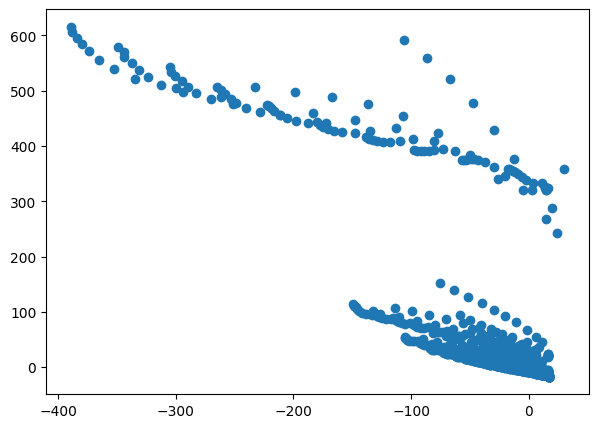

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(result_df["dec_vs"], result_df["acc_vs"])

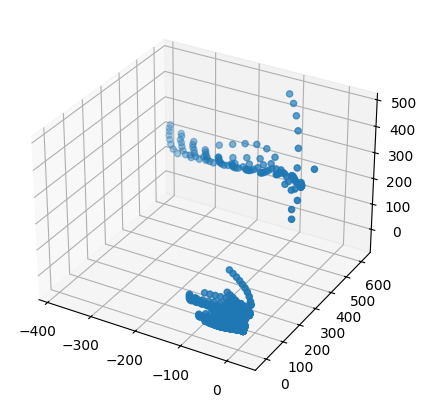

In [75]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={"projection": "3d"})
ax: Axes3D = ax
ax.scatter(result_df["dec_vs"], result_df["acc_vs"], result_df["total_vs"])